In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

import sys
sys.path.append("../src")

from dnadb import dna, fasta, sample
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tf_utilities as tfu
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
import wandb

from deepdna.data.dataset import Dataset
from deepdna.data import metrics, samplers
from deepdna.nn.data_generators import SampleTargetGenerator
from deepdna.nn.models import load_model, dnabert, setbert

In [3]:
tfu.devices.select_gpu(1)

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')])

In [4]:
SEED = 0

In [5]:
api = wandb.Api()

## Models

In [6]:
path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-128d-250l:v0").download()
dnabert_encoder = dnabert.DnaBertEncoderModel(
    load_model(path, dnabert.DnaBertPretrainModel).base,
    chunk_size=256
)

wandb: Downloading large artifact dnabert-pretrain-silva-128d-250l:v0, 61.32MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.1


In [7]:
path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v0").download()
setbert_pretrain_model = load_model(path, setbert.SetBertPretrainModel)

wandb: Downloading large artifact setbert-pretrain-walker-abund-128d-250l:v0, 91.05MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.1


In [8]:
setbert_encoder = setbert.SetBertEncoderModel(setbert_pretrain_model.base)

---

## Data

Create dataset instances.

In [9]:
fasta_db_path = "/home/dwl2x/work/Datasets/Walker_Alex/alex.fasta.db"
index_db_path = "/home/dwl2x/work/Datasets/Walker_Alex/alex.fasta.index.db/"
mapping_db_path = "/home/dwl2x/work/Datasets/Walker_Alex/alex.fasta.mapping.db/"
pathogen_load_path = "/home/dwl2x/work/Datasets/Walker_Alex/alex.pathogen_load.tsv"

# sample.load_multiplexed_fasta(fasta_db_path, index_db_path, mapping_db_path)

In [10]:
fasta_db = fasta.FastaDb(fasta_db_path)

In [11]:
index_db = fasta.FastaIndexDb(index_db_path)

In [12]:
mapping = sample.SampleMappingDb(mapping_db_path, index_db)

In [13]:
p = pd.read_csv(pathogen_load_path, sep="\t", index_col=0)
p

,pathogen_load
label,
STP582C,0.00000
STP633C,0.00000
STP634C,0.00000
STP639C,0.00000
STP640C,0.00000
...,...
STP1502C,0.30103
STP1503C,0.30103
STP762C,1.00000


In [15]:
all_samples = [sample.DemultiplexedFastaSample(fasta_db, entry) for entry in mapping]
len(all_samples)

737

In [16]:
targets = pd.read_csv(pathogen_load_path, sep="\t", index_col=0)["pathogen_load"].astype(np.float32).to_dict()

In [38]:
def compute_class_weights(samples, targets):
    negative_indices = np.array([1.0 if targets[sample.name] == 0.0 else 0.0 for sample in samples])
    positive_indices = 1 - negative_indices
    negative_weights = negative_indices / np.sum(negative_indices)
    positive_weights = positive_indices / np.sum(positive_indices)
    class_weights = positive_weights/2 + negative_weights/2
    return class_weights

rng = np.random.default_rng(SEED)
samples = rng.choice(all_samples, 10, replace=False, p=compute_class_weights(all_samples, targets))
len(samples)

/tmp/ipykernel_206418/1034511.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = rng.choice(all_samples, 10, replace=False, p=compute_class_weights(all_samples, targets))


10

In [39]:
sample_names = [sample.name for sample in samples]
sample_names

['CMFP74',
 'CMFP391',
 'CMFP128',
 'CMFP110',
 'STP1127C',
 'STP1488C',
 'CMFP721',
 'CMFP855',
 'CMFP670',
 'STP633C']

Draw random subsamples using the SequenceSampler.

In [40]:
seq_sampler = samplers.SequenceSampler(250)

In [30]:
rng = np.random.default_rng(SEED + 1)
subsamples_list = []
for i, sample in tqdm(enumerate(samples)):
    subsamples = []
    for j in range(10):
        print(f"\r{i+1:02d}: {j+1:02d}/{len(samples)}", end="")
        sequences = np.array(list(map(dna.encode_sequence, seq_sampler.sample(sample, 1000))))
        sequences = dna.encode_kmers(sequences, dnabert_encoder.base.kmer)
        sequences = dnabert_encoder.predict(sequences, batch_size=512, verbose=False)
        subsamples.append(sequences)
    subsamples_list.append(subsamples)
subsamples = np.array(subsamples_list)
subsamples.shape

0it [00:00, ?it/s]

10: 10/10

(10, 10, 1000, 128)

In [42]:
encoded_subsamples = []
for sample in samples:
    # print(f"\r{i+1:02d}/{len(samples)}", end="")
    subsamples = []
    for j in range(10):
        sequences = np.array(list(map(dna.encode_sequence, seq_sampler.sample(sample, 1000))))
        sequences = dna.encode_kmers(sequences, dnabert_encoder.base.kmer)
        # sequences = dnabert_encoder.predict(sequences, batch_size=512, verbose=False)
        subsamples.append(sequences)
    subsamples = np.array(subsamples)
    encoded_subsamples.append(setbert_encoder.predict(subsamples))
encoded_subsamples = np.array(encoded_subsamples)
encoded_subsamples.shape

1/1 [==============================] - 9s 9s/step


In [43]:
encoded_subsamples = np.array(encoded_subsamples)
encoded_subsamples.shape

(10, 10, 128)

In [44]:
# shape = subsamples.shape
# encoded_subsamples = setbert_encoder.predict(
#     tf.reshape(subsamples, (-1, *shape[2:])), batch_size=1).reshape((*shape[:2], shape[-1]))

## MDS Projections

In [45]:
distance_measure = "cityblock"
metric = True

In [46]:
flat: np.ndarray = encoded_subsamples.reshape((-1, encoded_subsamples.shape[-1]))
distance_matrix = cdist(flat, flat, distance_measure)
distance_matrix.shape

(100, 100)

In [47]:
mds, _ = metrics.mds(distance_matrix, ndim=2, metric=metric, seed=SEED)
mds = mds.reshape(len(samples), -1, 2)
mds.shape

(10, 10, 2)

In [48]:
def mds_stress_analysis(dist_mat, dims, metric=True, seed=None, workers=1, **kwargs):
    """
    Compute the MDS stress value for the given possible range of components.
    """
    import multiprocessing
    if isinstance(dims, int):
        dims = range(1, dims+1)
    dims = list(dims)
    with multiprocessing.Pool(workers) as pool:
        stresses = pool.map(metrics.MdsStressAnalysisProcess(
            dist_mat, metric=metric, random_state=seed, **kwargs
        ), dims)
    print(stresses)
    return dims, stresses #(1 - np.cumsum(stresses) / np.sum(stresses))

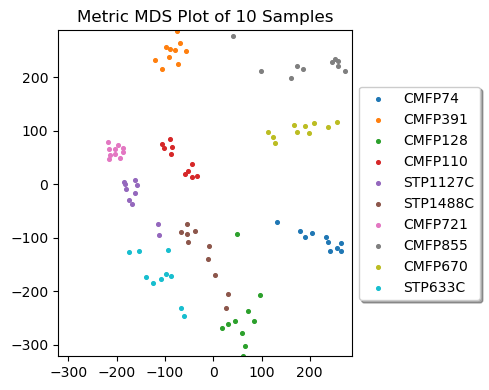

In [54]:
plt.figure(figsize=(5, 4))
# plt.subplot(1, 2, 1)
plt.title(f"Metric MDS Plot of {len(samples)} Samples")
for sample, points in zip(sample_names, mds):
    plt.scatter(points[:,0], points[:,1], label=sample, s=7)
plt.xlim((np.min(mds) - 1, np.max(mds) + 1))
plt.ylim((np.min(mds) - 1, np.max(mds) + 1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)

# plt.subplot(1, 2, 2)
# plt.title("MDS Stress Scree Plot")
# plt.plot(*mds_stress)
# plt.xlabel("Number of Components")
# plt.ylabel("1 - Cumulative Stress")
# plt.tight_layout()
# plt.savefig("mds_scree_plot.png")
plt.tight_layout()
plt.show()

In [52]:
mds_stress = metrics.mds_stress_analysis(distance_matrix, 128, metric=metric, seed=SEED, workers=1)

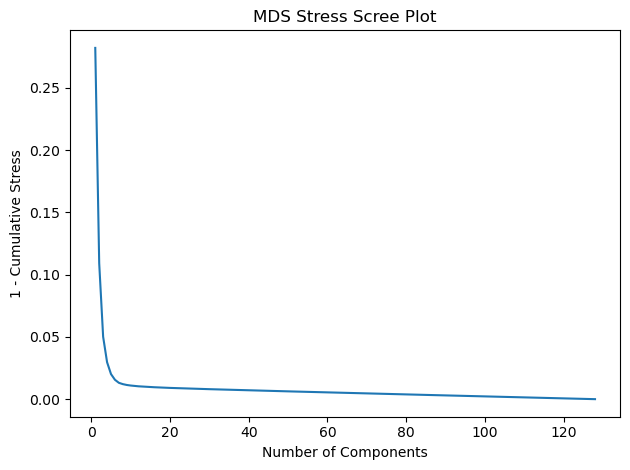

In [55]:
plt.title("MDS Stress Scree Plot")
plt.plot(*mds_stress)
plt.xlabel("Number of Components")
plt.ylabel("1 - Cumulative Stress")
plt.tight_layout()
plt.show()

## Clustering

In [ ]:
encoded_subsamples.shape

In [ ]:
flat_encoded_samples = encoded_subsamples.reshape((-1, encoded_subsamples.shape[-1]))

In [ ]:
kmeans = KMeans(n_clusters=len(encoded_subsamples))
labels = kmeans.fit_predict(flat_encoded_samples)
labels

In [ ]:
normalized_mutual_info_score(
    np.repeat(np.arange(len(encoded_subsamples)), encoded_subsamples.shape[1]),
    labels)

### Agglomerative Clustering

In [ ]:
model = AgglomerativeClustering(None, distance_threshold=0).fit(flat_encoded_samples)
# model = AgglomerativeClustering(len(encoded_subsamples)).fit(flat_encoded_samples)

In [42]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [43]:
model.labels_

array([85, 69, 53, 54, 98, 78, 97, 73, 63, 61, 79, 58, 71, 81, 91, 65, 89,
       83, 66, 95, 96, 93, 92, 64, 90, 68, 74, 72, 99, 76, 87, 84, 35, 82,
       70, 32, 50, 67, 45, 48, 57, 51, 60, 77, 55, 75, 47, 36, 94, 80, 88,
       31, 49, 23, 56, 46, 15, 27, 37, 52, 40, 38, 24, 62, 18, 39, 86, 59,
       26, 25, 19, 44, 12, 28, 34, 11, 17, 41, 42, 29, 43,  8, 30, 20, 22,
       21, 14, 33, 16, 10,  9, 13,  6,  7,  3,  4,  5,  2,  1,  0])

[  2.   2.   2.   2.   2.   2.   2.   2.   2.   3.   2.   2.   2.   3.
   2.   2.   2.   2.   2.   2.   2.   3.   2.   3.   3.   3.   4.   2.
   3.   3.   3.   4.   4.   4.   3.   2.   2.   2.   2.   2.   3.   3.
   2.   2.   2.   6.   2.   4.   2.   5.   3.   4.   6.   8.   7.   2.
   3.   3.   4.   9.   3.   3.   4.   3.   6.   7.   9.   7.   2.   4.
   5.   7.   2.   5.   6.   8.   8.   7.   6.  10.  10.   7.   9.  10.
   4.  10.  11.  12.  10.  10.  20.  20.  20.  30.  20.  30.  50.  50.
 100.]


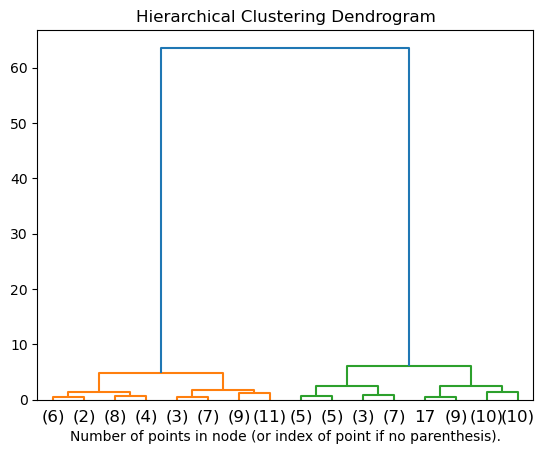

In [44]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()